# Оптимизация производственнх расходов металлургического комбината 

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру стали.

# Описание этапов обработки стали

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат.

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов.

# Описание данных

Данные состоят из файлов, полученных из разных источников:

- data_arc.csv — данные об электродах;
- data_bulk.csv — данные о подаче сыпучих материалов (объём);
- data_bulk_time.csv — данные о подаче сыпучих материалов (время);
- data_gas.csv — данные о продувке сплава газом;
- data_temp.csv — результаты измерения температуры;
- data_wire.csv — данные о проволочных материалах (объём);
- data_wire_time.csv — данные о проволочных материалах (время).

Во всех файлах столбец *key* содержит номер партии. В файлах может быть несколько строк с одинаковым значением *key*: они соответствуют разным итерациям обработки.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, make_scorer

import warnings
warnings.filterwarnings('ignore')

from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [2]:
data_arc = pd.read_csv('C:/Users/leoci/Downloads/final_steel/data_arc.csv')
data_bulk = pd.read_csv('C:/Users/leoci/Downloads/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('C:/Users/leoci/Downloads/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('C:/Users/leoci/Downloads/final_steel/data_gas.csv')
data_temp = pd.read_csv('C:/Users/leoci/Downloads/final_steel/data_temp.csv')
data_wire = pd.read_csv('C:/Users/leoci/Downloads/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('C:/Users/leoci/Downloads/final_steel/data_wire_time.csv')

### data_arc

In [3]:
display(data_arc.head(10))
print(data_arc.info())

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None


In [4]:
print(data_arc.duplicated().sum())

0


Датасет содержит 14876 строк и 5 столбцов:
- key - номер партии
- Время начала нагрева
- Время окончания нагрева
- Активная мощность
- Реактивная мощность
  
Дубликаты в данных отсутствуют, пропуски в данных отсутствуют.

Зададим названия столбцов для более удобной работы

In [5]:
data_arc.columns = ['key', 'start_heating', 'finish_heating', 'real_power', 'reactive_power']

Преобразуем формат времени в datetime, найдем длительность каждого нагрева в секундах.

In [6]:
data_arc['finish_heating'] = pd.to_datetime(data_arc['finish_heating'], format = '%Y-%m-%d %H:%M:%S')
data_arc['start_heating'] = pd.to_datetime(data_arc['start_heating'], format = '%Y-%m-%d %H:%M:%S')

In [7]:
data_arc['heating_duration_sek'] = data_arc['finish_heating'] - data_arc['start_heating']
data_arc['heating_duration_sek'] = data_arc['heating_duration_sek'].apply(lambda x: x.total_seconds())

Проанализируем данные методом describe

In [8]:
display(data_arc.describe())

,key,real_power,reactive_power,heating_duration_sek
count,14876.000000,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592,171.670946
std,934.571502,0.408159,5.878702,98.186803
min,1.000000,0.030002,-715.504924,11.000000
25%,806.000000,0.395297,0.290991,107.000000
50%,1617.000000,0.555517,0.415962,147.000000
75%,2429.000000,0.857034,0.637371,214.000000
max,3241.000000,3.731596,2.676388,907.000000


Виден аномальный минимум в реактивной мощности. Посмотрим его отдельно

In [9]:
display(data_arc.query('reactive_power < 0'))

,key,start_heating,finish_heating,real_power,reactive_power,heating_duration_sek
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924,109.0


Удалим данный выброс

In [10]:
data_arc = data_arc.query('key != 2116')

Сгруппируем данные по номеру партии. Затраченные мощности и время нагрева просуммируем. Добавим столбец с количеством запусков нагрева электродами

In [11]:
data_arc_grouped = data_arc.groupby('key').sum()
data_arc_grouped['launches_number'] = data_arc.groupby('key')['real_power'].count()
display(data_arc_grouped.head())
display(data_arc_grouped.describe())

,real_power,reactive_power,heating_duration_sek,launches_number
key,,,,
1,4.878147,3.183241,1098.0,5
2,3.052598,1.998112,811.0,4
3,2.525882,1.599076,655.0,5
4,3.209250,2.060298,741.0,4
5,3.347173,2.252643,869.0,4


,real_power,reactive_power,heating_duration_sek,launches_number
count,3213.000000,3213.000000,3213.000000,3213.000000
mean,3.103529,2.317879,794.691566,4.628696
std,1.397432,1.054189,332.439136,1.608860
min,0.186226,0.158247,57.000000,1.000000
25%,2.126654,1.599076,571.000000,4.000000
50%,2.990755,2.230260,770.000000,4.000000
75%,3.901463,2.899524,983.000000,6.000000
max,17.496497,12.587990,4189.000000,16.000000


Построим боксплоты и гистограммы распределения величин.

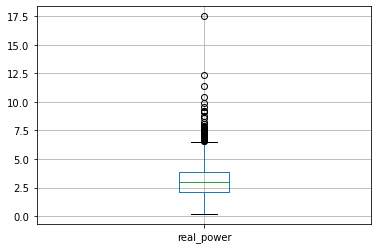

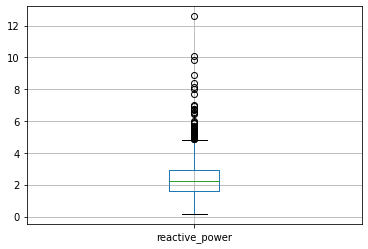

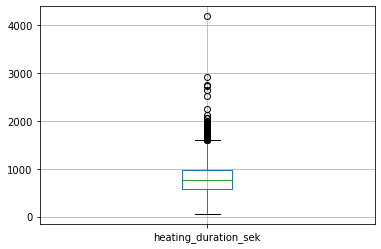

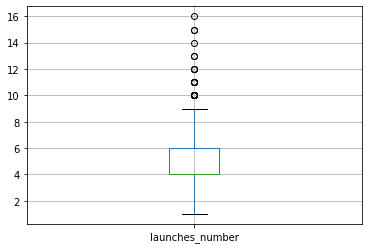

In [12]:
for column in data_arc_grouped.columns:
    data_arc_grouped.boxplot(column)
    plt.show()

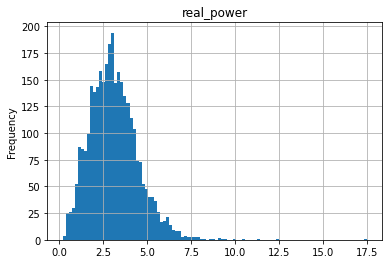

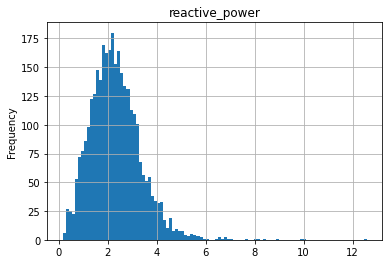

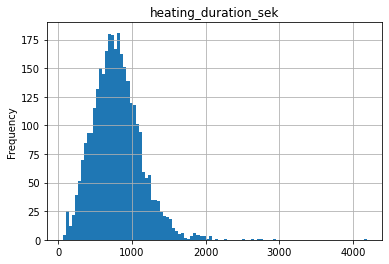

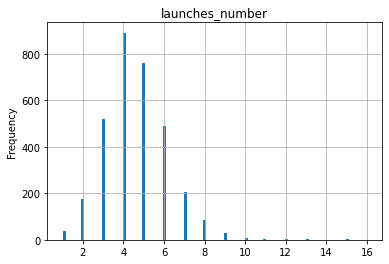

In [13]:
for column in data_arc_grouped.columns:
    data_arc_grouped[column].plot(kind='hist', bins=100, grid=True, title=column)
    plt.show()

В данных есть незначительное количество выбросов по каждому из параметров. Удалим выбросы, ограничив значения каждого параметра.

In [14]:
data_arc_grouped = data_arc_grouped.query('real_power < 8 and reactive_power < 6 \
                                          and heating_duration_sek < 2000 and launches_number <= 10')

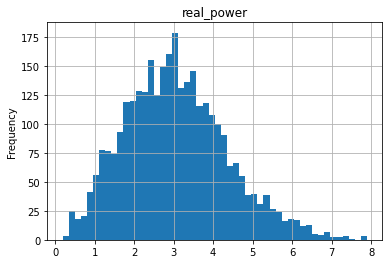

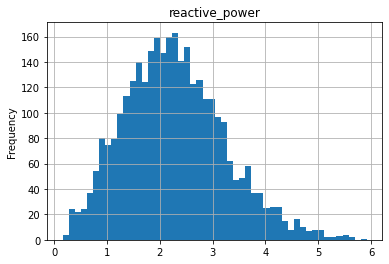

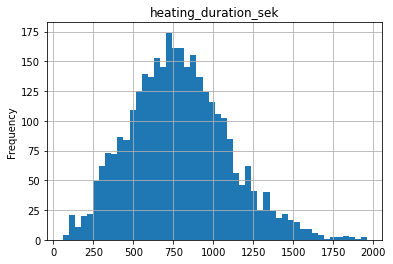

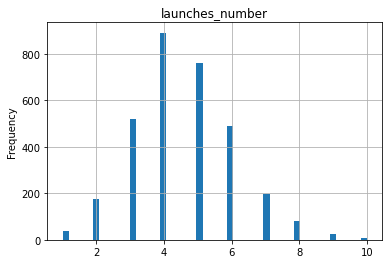

In [15]:
for column in data_arc_grouped.columns:
    data_arc_grouped[column].plot(kind='hist', bins=50, grid=True, title=column)
    plt.show()

Посмотрим, общую информацию о данных после очистки от выбросов.

In [16]:
display(data_arc_grouped.describe())

,real_power,reactive_power,heating_duration_sek,launches_number
count,3185.000000,3185.000000,3185.000000,3185.000000
mean,3.058802,2.278620,783.510832,4.578964
std,1.295738,0.955057,306.779217,1.503387
min,0.186226,0.158247,57.000000,1.000000
25%,2.122530,1.592806,569.000000,4.000000
50%,2.982119,2.219266,766.000000,4.000000
75%,3.867637,2.875611,977.000000,6.000000
max,7.893591,5.921184,1960.000000,10.000000


### data_bulk

In [17]:
display(data_bulk.head(10))
print(data_bulk.info())
display(data_bulk.describe())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [18]:
print(data_bulk.duplicated().sum())

0


Датасет содержит 3129 строк и 16 столбцов:
- key - номер партии
- Bulk - номер легирующей добавки
  
Дубликаты в данных отсутствуют.

Пропуски в данных означают, что данная добавка не вводилась в расплав, тоесть их можно заменить нулями.

5 видов добавок использовали меньше чем в 25 партиях, а всего партий больше 3000.

В данных есть выбросы, например очень болшой максимум в столбце Bulk 12

In [19]:
print(data_bulk['key'].value_counts().count())

3129


Номера партий в таблице не повторяются

Переименуем столбцы

In [20]:
data_bulk.columns = ['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9',
                    'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']

### data_bulk_time

In [21]:
display(data_bulk_time.head(10))
print(data_bulk_time.info())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None


In [22]:
data_bulk_time.columns = ['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9',
                          'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']

Данная таблица соответствует предыдущей, в этой указано время, в которое была сделана легирующая добавка.

### data_gas

In [23]:
display(data_gas.head(10))
print(data_gas.info())
display(data_gas.describe())

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [24]:
print(data_gas.duplicated().sum())

0


Пропусков в данных нет, дубликатов тоже.

In [25]:
data_gas.columns = ['key', 'gas']

In [26]:
print(data_gas['key'].value_counts().count())

3239


Номера партий в таблице не повторяются

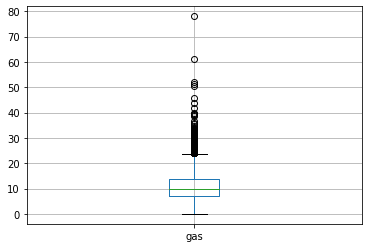

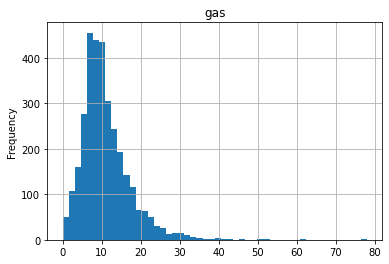

In [27]:
data_gas.boxplot('gas')
plt.show()
data_gas['gas'].plot(kind='hist', bins=50, grid=True, title='gas')
plt.show()

Ограничим значения gas, чтобы избавиться от выбросов.

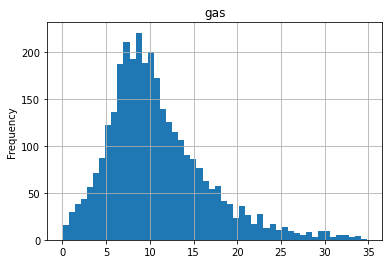

In [28]:
data_gas = data_gas.query('gas < 35')
data_gas['gas'].plot(kind='hist', bins=50, grid=True, title='gas')
plt.show()

### data_temp

In [29]:
display(data_temp.head(15))
print(data_temp.info())
display(data_temp.describe())

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
None


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


In [30]:
print(data_temp.duplicated().sum())

0


Дубликатов в данных нет, пропусков тоже.

Переименуем столбцы, преобразуем формат данных.

In [31]:
data_temp.columns = ['key', 'time', 'temperature']
data_temp['time'] = pd.to_datetime(data_temp['time'], format = '%Y-%m-%d %H:%M:%S')

Температура плавления стали зависит от конкретного сплава, но начинается с 1450 градусов Цельсия. При производстве сталь жидкая. Поэтому, минимальное значение в 1191 градус является ошибкой в данных. Проверим, сколько еще измерений показали температуру меньше температуры плавления стали.

In [32]:
print(data_temp.query('temperature < 1450'))

        key                time  temperature
4350    867 2019-06-04 14:21:00       1191.0
5978   1214 2019-06-16 05:32:00       1208.0
7958   1619 2019-06-30 11:03:54       1218.0
8913   1818 2019-07-07 00:30:49       1383.0
8914   1818 2019-07-07 00:31:40       1383.0
10127  2052 2019-07-21 14:51:40       1227.0
12564  2561 2019-08-08 07:34:15       1204.0


Данные строки - ошибки в измерениях. Их необходимо удалить.

In [33]:
data_temp = data_temp.query('temperature > 1450')
print(data_temp.describe())

                key   temperature
count  12999.000000  12999.000000
mean    1328.243942   1592.020078
std      804.821269     19.853665
min        1.000000   1519.000000
25%      638.000000   1581.000000
50%     1315.000000   1591.000000
75%     1977.500000   1601.000000
max     3241.000000   1705.000000


Сгруппируем значения по номеру партии. В итоговой таблице создадим следующие столбцы: 
- разница в секундах между первым и последним измерением температуры
- первая измеренная температура
- последняя измеренная температура

In [34]:
data_temp_grouped_first = data_temp.groupby('key').first()
data_temp_grouped_last = data_temp.groupby('key').last()
data_temp_grouped = data_temp_grouped_first.merge(data_temp_grouped_last, on='key')
data_temp_grouped['temperature_measurement_time_delta'] = data_temp_grouped['time_y'] - data_temp_grouped['time_x']
data_temp_grouped['temperature_measurement_time_delta'] = data_temp_grouped['temperature_measurement_time_delta'] \
                                                                           .apply(lambda x: x.total_seconds())
data_temp_grouped = data_temp_grouped.drop(['time_x', 'time_y'], axis=1)
data_temp_grouped.columns = ['temperature_first', 'temperature_last', 'temperature_measurement_time_delta']

In [35]:
display(data_temp_grouped.describe())

,temperature_first,temperature_last,temperature_measurement_time_delta
count,3215.000000,3215.000000,3215.000000
mean,1589.195023,1594.049767,1427.492691
std,25.015034,18.649454,1383.004290
min,1519.000000,1529.000000,0.000000
25%,1572.000000,1585.000000,608.500000
50%,1588.000000,1593.000000,1334.000000
75%,1606.000000,1600.000000,2001.000000
max,1684.000000,1700.000000,23537.000000


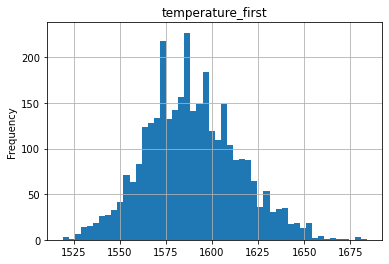

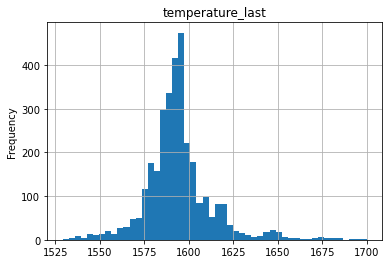

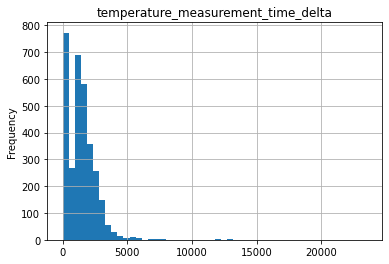

In [36]:
for column in data_temp_grouped.columns:
    data_temp_grouped[column].plot(kind='hist', bins=50, grid=True, title=column)
    plt.show()

Отсеим данные - явные выбросы, в которых процесс обработки длился больше 5000 секунд.

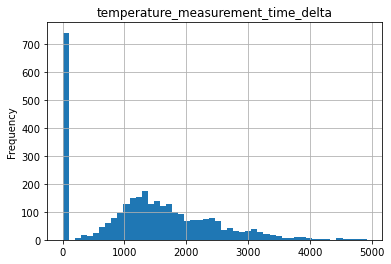

In [37]:
data_temp_grouped = data_temp_grouped.query('temperature_measurement_time_delta < 5001')
data_temp_grouped['temperature_measurement_time_delta'].plot(kind='hist', bins=50, grid=True, title='temperature_measurement_time_delta')
plt.show()

Больше 700 раз встречается время между измерениями температуры равное 0. Это партии, в которых температура была измерена всего 1 раз. Проверим это на первоначальных данных до группировки.

In [38]:
data_count = data_temp.groupby('key').count()
print(data_count[data_count['time'] == 1]['time'].count())

740


Итого 740 партий, в которых температуру измеряли всего 1 раз. Удалим эти данные.

In [39]:
data_temp_grouped = data_temp_grouped.query('temperature_measurement_time_delta > 1')

In [40]:
print(data_temp_grouped.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2437 entries, 1 to 2499
Data columns (total 3 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   temperature_first                   2437 non-null   float64
 1   temperature_last                    2437 non-null   float64
 2   temperature_measurement_time_delta  2437 non-null   float64
dtypes: float64(3)
memory usage: 76.2 KB
None


### data_wire

In [41]:
display(data_wire.head(10))
print(data_wire.info())
display(data_wire.describe())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [42]:
data_wire.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']

Пропуски в данных означают не использование данной проволоки в данной партии. Их можно заменить нулями.

В большинстве случаев использовалась проволока 1 и 2, все остальные использовались не больше, чем в 75 партиях, что стоставляет меньше 2% случаев.

In [43]:
print(data_wire['key'].value_counts().count())

3081


Номера партий не повторяются.

### data_wire_time

In [44]:
display(data_wire_time.head(10))
print(data_wire_time.info())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None


In [45]:
data_wire_time.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']

In [46]:
print(data_wire_time['key'].value_counts().count())

3081


Таблица соответствует предыдущей, с указанием времени подачи проволоки.

## Создание общей таблицы

In [47]:
data_all = data_arc_grouped.merge(data_temp_grouped, on='key', how='inner')

In [48]:
display(data_arc_grouped.info())
display(data_temp_grouped.info())
display(data_all.info())
display(data_all.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3185 entries, 1 to 3241
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   real_power            3185 non-null   float64
 1   reactive_power        3185 non-null   float64
 2   heating_duration_sek  3185 non-null   float64
 3   launches_number       3185 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 124.4 KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2437 entries, 1 to 2499
Data columns (total 3 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   temperature_first                   2437 non-null   float64
 1   temperature_last                    2437 non-null   float64
 2   temperature_measurement_time_delta  2437 non-null   float64
dtypes: float64(3)
memory usage: 76.2 KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2426 entries, 1 to 2499
Data columns (total 7 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   real_power                          2426 non-null   float64
 1   reactive_power                      2426 non-null   float64
 2   heating_duration_sek                2426 non-null   float64
 3   launches_number                     2426 non-null   int64  
 4   temperature_first                   2426 non-null   float64
 5   temperature_last                    2426 non-null   float64
 6   temperature_measurement_time_delta  2426 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 151.6 KB


None

,real_power,reactive_power,heating_duration_sek,launches_number,temperature_first,temperature_last,temperature_measurement_time_delta
key,,,,,,,
1,4.878147,3.183241,1098.0,5,1571.0,1613.0,861.0
2,3.052598,1.998112,811.0,4,1581.0,1602.0,1305.0
3,2.525882,1.599076,655.0,5,1596.0,1599.0,1300.0
4,3.209250,2.060298,741.0,4,1601.0,1625.0,388.0
5,3.347173,2.252643,869.0,4,1576.0,1602.0,762.0


В объединенных двух таблицах содержится ключевая информация, такая как мощность, длительность нагрева, начальная и конечная температуры. Если данная информация отсутствует, то нельзя предсказать конечный результат основываясь только на наличии легирующих добавок. Поэтому, на данном этапе, объединили таблицы методом inner.

Добавим в таблицу информацию про инертный газ. На данном этапе будем добавлять данные методом left, т.к. нас интересуют только номера партий, про которые есть ключевая информация.

In [49]:
data_all = data_all.merge(data_gas, on='key', how='left')
print(data_all.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2426 entries, 0 to 2425
Data columns (total 9 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   key                                 2426 non-null   int64  
 1   real_power                          2426 non-null   float64
 2   reactive_power                      2426 non-null   float64
 3   heating_duration_sek                2426 non-null   float64
 4   launches_number                     2426 non-null   int64  
 5   temperature_first                   2426 non-null   float64
 6   temperature_last                    2426 non-null   float64
 7   temperature_measurement_time_delta  2426 non-null   float64
 8   gas                                 2416 non-null   float64
dtypes: float64(7), int64(2)
memory usage: 189.5 KB
None


Всего 10 данных имеют пропуски. Удалим их, раз их так мало.

In [50]:
data_all = data_all.dropna()

Создадим общую таблицу с легирующими добавками. Объединим таблицы с сыпучими материалами и с проволоками методом outer, потому что на данном этапе необходимы все существующие данные.

In [51]:
data_aggregates = data_bulk.merge(data_wire, on='key', how='outer')

In [52]:
display(data_aggregates.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3185 entries, 0 to 3184
Data columns (total 25 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3185 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
 16  wire_1   3055 non-null   float64
 17  wire_2   1079 non-null   float64
 18  wire_3   63 non-null     float64
 19  wire_4   14 non-null     float64
 20  wire_5   1 non-null      float64
 21  wire_6   73 no

None

Удалим добавки, которые использовались меньше 30 раз. Это использование в меньше чем 1% случаев, данных слишком мало, чтобы они могли положительно повлиятьт на обучение модели.

В оставшихся данных заполним пропуски нулями.

In [53]:
data_aggregates = data_aggregates.fillna(0)

In [54]:
data_aggregates = data_aggregates.drop(['bulk_2', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_13', 'wire_4', 'wire_5', 'wire_7', 'wire_8', 'wire_9'], axis=1)

Построим heatmap для каждой из таблиц, проверим признаки на мультиколлинеарность.

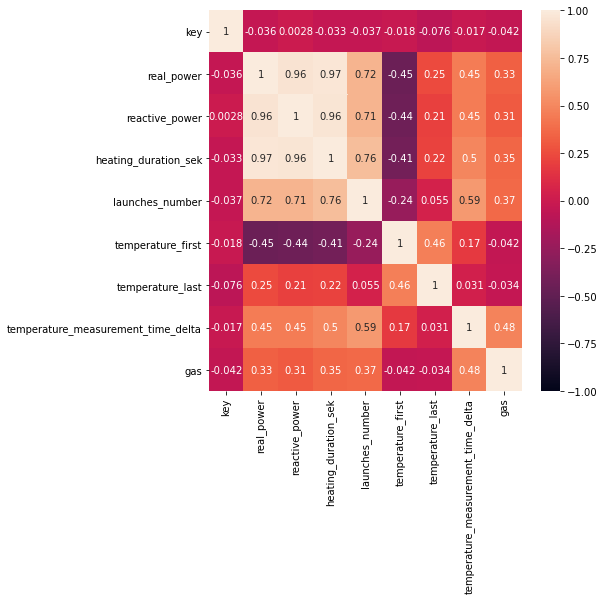

In [55]:
plt.figure(figsize=(7,7))
heatmap = sns.heatmap(data_all.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

Наблюдается сильная линейная зависимость между активной мощностью, реактивной мощностью и продолжительностью нагрева. Это естественно, т.к. все 3 эти величины связаны известными физическими формулами и получаются одна из другой. Так же достаточно высокая корреляция этих трёх величин с количеством включений нагрева, потому что от этого количества сильно зависит общая продолжительность нагрева.

Таким образом, для обучения модели необходимо оставить одну из этих величин, например, продолжительность нагрева в секундах.

In [56]:
data_all = data_all.drop(['real_power', 'reactive_power', 'launches_number'], axis=1)

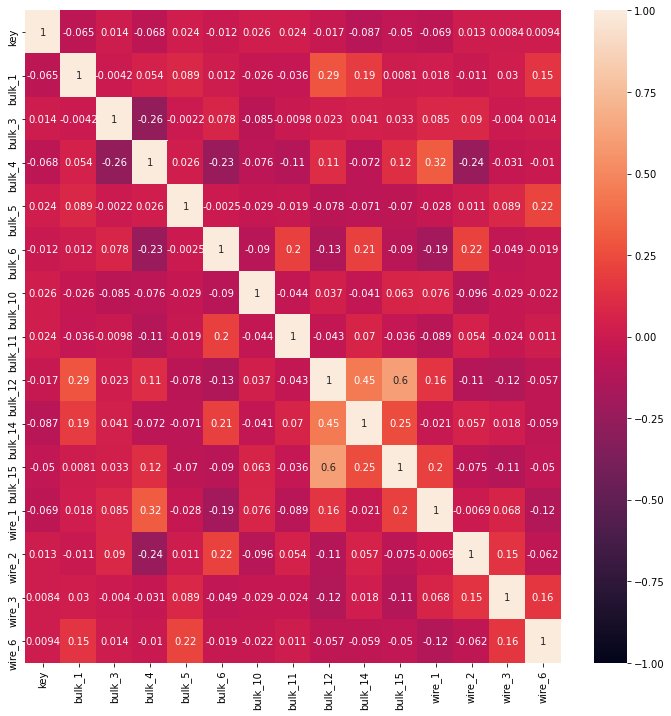

In [57]:
plt.figure(figsize=(12,12))
heatmap = sns.heatmap(data_aggregates.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

Объединим таблицу с основной информацией и таблицу с добавками методом left.

In [58]:
data_all = data_all.merge(data_aggregates, on='key', how='left')

In [59]:
print(data_all.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2416 entries, 0 to 2415
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   key                                 2416 non-null   int64  
 1   heating_duration_sek                2416 non-null   float64
 2   temperature_first                   2416 non-null   float64
 3   temperature_last                    2416 non-null   float64
 4   temperature_measurement_time_delta  2416 non-null   float64
 5   gas                                 2416 non-null   float64
 6   bulk_1                              2389 non-null   float64
 7   bulk_3                              2389 non-null   float64
 8   bulk_4                              2389 non-null   float64
 9   bulk_5                              2389 non-null   float64
 10  bulk_6                              2389 non-null   float64
 11  bulk_10                             2389 no

Есть 27 строк, в которых полностью отсутствует информация о легирующих добавках. Процент таких данных достаточно маленький, поэтому удалим их.

In [60]:
data_all = data_all.dropna()

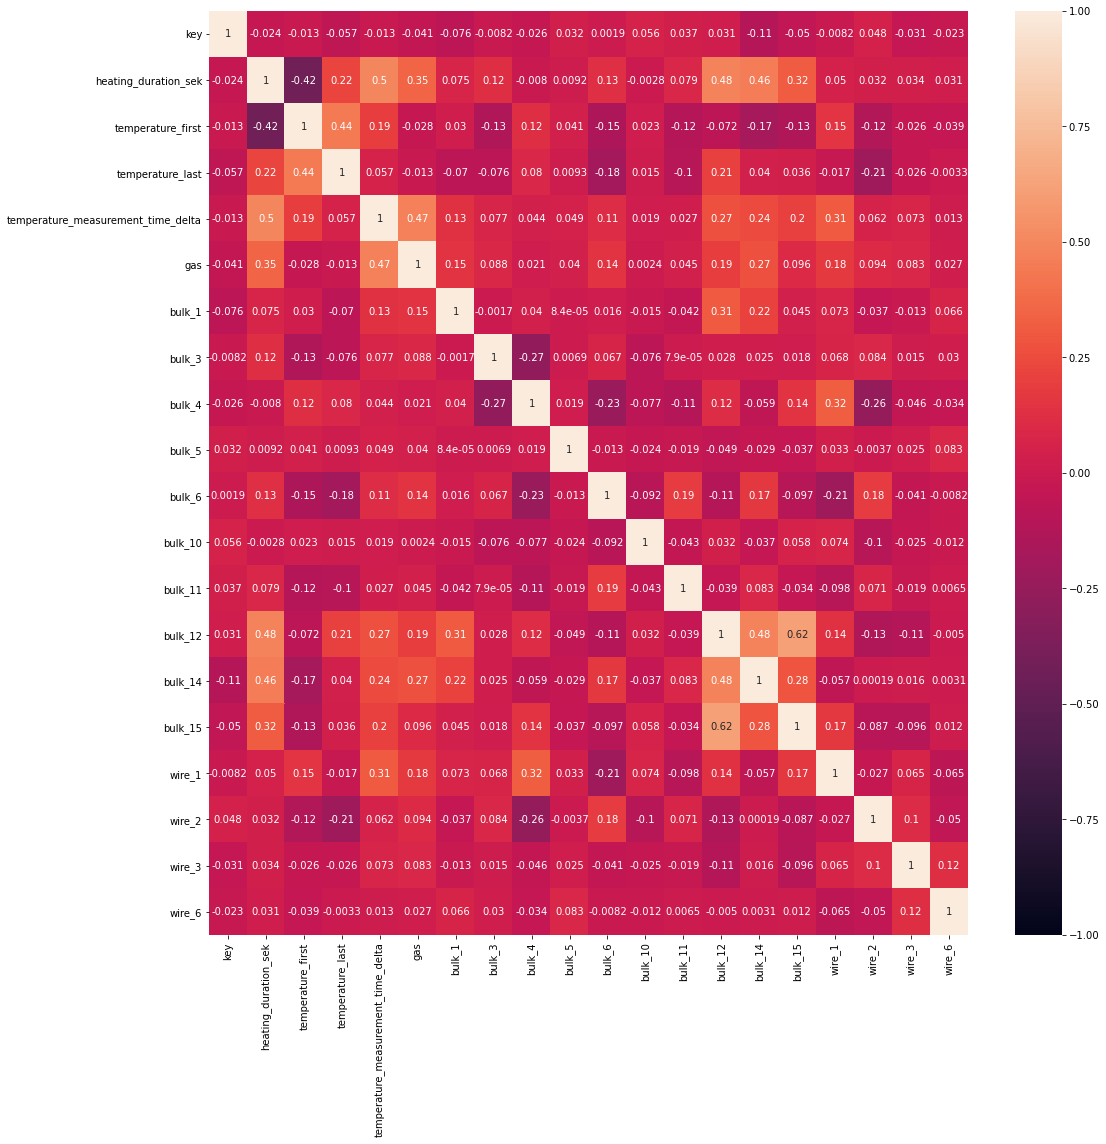

In [61]:
plt.figure(figsize=(17,17))
heatmap = sns.heatmap(data_all.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

## Вывод

Данные проанализированы, очищены от выбросов, приведены к удобному для работы виду. Построена матрица корреляций, удалены признаки, приводящие к мультиколлинеарности.

# План работы

1. Провести статистический анализ данных (выполнено)
2. Объединить таблицы с признаками в одну, оставить необходимые признаки (выполнено)
3. Разделить данные на признаки и целевой признак. Разделить на тестовую, валидационную и тренировочную выборки
4. Обучить различные модели, сравнить качество, проанализировать результат. При необходимости, провести более тщательную предобработку данных, возможно сделть генерацию дополнительных признаков. Выбрать оптимальную модель
5. Сделать выводы по работе

# Обучение модели

Разделим данные на признаки и целевой признак. Поделим данные на обучающую, валидационную и тестовую выборки.

In [62]:
X = data_all.drop(['temperature_last', 'key'], axis=1)
y = data_all['temperature_last']

X_pre_train, X_test, y_pre_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)
X_train, X_valid, y_train, y_valid = train_test_split(X_pre_train, y_pre_train, test_size=0.25, random_state=123)

In [63]:
feature_names = X_train.columns

Произведем масштабирование данных.

In [64]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

Обучим разные модели.

### Линейная регрессия

In [65]:
%%time

model1 = LinearRegression()
model1.fit(X_train, y_train)
pred1 = model1.predict(X_valid)
print(f'MAE модели LinearRegression: {mean_absolute_error(y_valid, pred1):.3f}')

MAE модели LinearRegression: 7.336
Wall time: 12 ms


### Случайный лес

Для случайного леса подберем параметры при помощи GridSearchCV

In [66]:
%%time

model = RandomForestRegressor(random_state=123)
params = {'max_depth': np.arange(6, 21, 2), 'n_estimators': np.arange(80,151,10)}
grid = GridSearchCV(model, params, scoring='neg_mean_absolute_error', cv=2)
grid.fit(X_train, y_train)

print('Комбинация параметров, которая дает лучший результат:', grid.best_params_)
print(f'Минимальный MAE: {abs(grid.best_score_):.3f}')

Комбинация параметров, которая дает лучший результат: {'max_depth': 14, 'n_estimators': 140}
Минимальный MAE: 6.290
Wall time: 49.2 s


Обучим модель с полученными параметрами и проверим на валидационной выборке.

In [67]:
%%time

model2 = RandomForestRegressor(n_estimators=140, max_depth=14, random_state=123)
model2.fit(X_train, y_train)
pred2 = model2.predict(X_valid)
print(f'MAE модели RandomForest: {mean_absolute_error(y_valid, pred2):.3f}')

MAE модели RandomForest: 6.562
Wall time: 907 ms


### Решающее дерево

In [68]:
%%time

model3 = DecisionTreeRegressor(random_state=123)
model3.fit(X_train, y_train)
pred3 = model3.predict(X_valid)
print(f'MAE модели DecisionTree: {mean_absolute_error(y_valid, pred3):.3f}')

MAE модели DecisionTree: 8.910
Wall time: 12 ms


### LGBMRegressor

In [69]:
%%time

model = LGBMRegressor(random_state=123)
params = {'max_depth': np.arange(1, 21, 2), 'n_estimators': np.arange(50,221,10)}
grid = GridSearchCV(model, params, scoring='neg_mean_absolute_error', cv=2)
grid.fit(X_train, y_train)

print('Комбинация параметров, которая дает лучший результат:', grid.best_params_)
print(f'Минимальный MAE: {abs(grid.best_score_):.3f}')

Комбинация параметров, которая дает лучший результат: {'max_depth': 3, 'n_estimators': 90}
Минимальный MAE: 6.063
Wall time: 18.9 s


In [70]:
%%time

model4 = LGBMRegressor(max_depth = 3, n_estimators=90, random_state=123)
model4.fit(X_train, y_train)

pred4 = model4.predict(X_valid)
print(f'MAE модели LGBMRegressor: {mean_absolute_error(y_valid, pred4):.3f}')

MAE модели LGBMRegressor: 6.419
Wall time: 22 ms


### CatBoostRegressor

In [71]:
%%time

model = CatBoostRegressor(random_seed=123, loss_function='RMSE', verbose=0)
params = {'learning_rate': np.arange(0.028, 0.036, 0.002), 'iterations': np.arange(500,800,50)}
grid = GridSearchCV(model, params, scoring='neg_mean_absolute_error', cv=2)
grid.fit(X_train, y_train)

print('Комбинация параметров, которая дает лучший результат:', grid.best_params_)
print(f'Минимальный MAE: {abs(grid.best_score_):.3f}')

Комбинация параметров, которая дает лучший результат: {'iterations': 500, 'learning_rate': 0.028}
Минимальный MAE: 5.957
Wall time: 38.4 s


In [72]:
%%time

model5 = CatBoostRegressor(loss_function='RMSE', iterations=500, learning_rate=0.028, random_seed=123)
model5.fit(X_train, y_train, verbose=50)

pred5 = model5.predict(X_valid)
print(f'MAE модели CatBoostRegressor: {mean_absolute_error(y_valid, pred5):.3f}')

0:	learn: 14.3939949	total: 49.6ms	remaining: 24.8s
50:	learn: 9.4582738	total: 121ms	remaining: 1.07s
100:	learn: 7.9500676	total: 195ms	remaining: 772ms
150:	learn: 7.2756558	total: 270ms	remaining: 624ms
200:	learn: 6.8607718	total: 341ms	remaining: 508ms
250:	learn: 6.5425861	total: 411ms	remaining: 407ms
300:	learn: 6.2690533	total: 488ms	remaining: 322ms
350:	learn: 6.0199352	total: 558ms	remaining: 237ms
400:	learn: 5.8179074	total: 627ms	remaining: 155ms
450:	learn: 5.6266067	total: 698ms	remaining: 75.9ms
499:	learn: 5.4403134	total: 768ms	remaining: 0us
MAE модели CatBoostRegressor: 6.269
Wall time: 838 ms


Наилучший результат на валидационных данных показала модель CatBoostRegressor. 

Проверим работу моделей на тестовой выборке.

In [73]:
pred_test1 = model1.predict(X_test)
print(f'MAE модели LinearRegression: {mean_absolute_error(y_test, pred_test1):.3f}')
pred_test2 = model2.predict(X_test)
print(f'MAE модели RandomForest: {mean_absolute_error(y_test, pred_test2):.3f}')
pred_test3 = model3.predict(X_test)
print(f'MAE модели DecisionTree: {mean_absolute_error(y_test, pred_test3):.3f}')
pred_test4 = model4.predict(X_test)
print(f'MAE модели LGBMRegressor: {mean_absolute_error(y_test, pred_test4):.3f}')
pred_test5 = model5.predict(X_test)
print(f'MAE модели CatBoostRegressor: {mean_absolute_error(y_test, pred_test5):.3f}')

MAE модели LinearRegression: 6.355
MAE модели RandomForest: 5.621
MAE модели DecisionTree: 8.218
MAE модели LGBMRegressor: 5.500
MAE модели CatBoostRegressor: 5.290


In [74]:
table = pd.DataFrame({'Модель': ['DecisionTree', 'LinearRegression', 'RandomForest', 'LGBM', 'CatBoost'], \
                      'MAE на тестовой выборке': ['8.218', '6.355', '5.621', '5.500', '5.290'], \
                      'Время на fit и predict': ['12 ms', '12 ms', '907 ms', '22 ms', '838 ms']})

## Вывод

Наилучший результат MAE на тестовой выборке, который удалось получить: MAE = 5.29

Проанализируем влияние факторов на целевой признак.

In [75]:
importance = pd.DataFrame({'feature_importance': model5.get_feature_importance(), 
              'feature_names': feature_names}).sort_values(by=['feature_importance'], ascending=True)

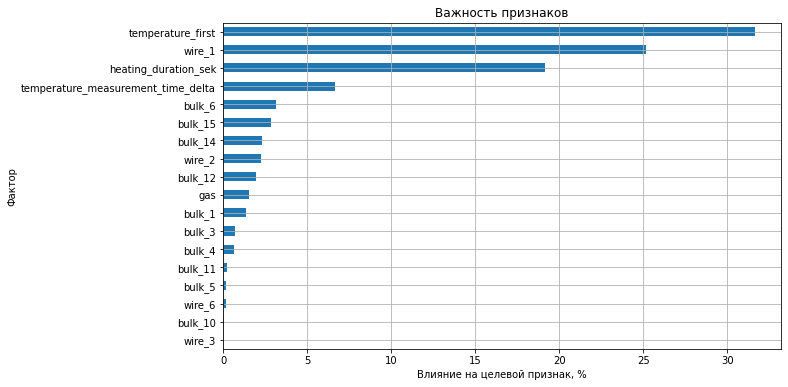

In [76]:
importance.plot.barh(x='feature_names', y='feature_importance', legend=False, figsize=(10,6), grid=True)
plt.title('Важность признаков')
plt.xlabel('Влияние на целевой признак, %')
plt.ylabel('Фактор')
plt.show()

Наибольшее влияние на целевой признак оказывают: начальная температура расплава, количество легирующей добавки в виде проволоки wire_1 и продолжительность нагрева электродами. Сыпучие добавки 11, 5, 10 и проволоки 6, 3 имеют влияние меньше 1%, следовательно их можно не учитывать при моделировании.

# Выводы по работе

В данной работе были получены данные со сталелитейного производства о процессе производства стали в дуговой электроплавильной печи. Данные были предоставлены в разных таблицах.

В ходе работы данные были проанализированы, очищены от выбросов, удалены ошибки в данных. Вся информация была собрана в единую таблицу.

Было обучено несколько различных моделей, результаты работы которых представлены в таблице.

In [77]:
display(table)

,Модель,MAE на тестовой выборке,Время на fit и predict
0,DecisionTree,8.218,20.8 ms
1,LinearRegression,6.355,22.4 ms
2,RandomForest,5.621,1.64 s
3,LGBM,5.500,52.1 ms
4,CatBoost,5.290,1.48 s


Наилучший результат на тестовой выборке выдает модель CatBoostRegressor. 

Однако, стоит отметить, что модель LGBMRegressor так же показывает хороший результат, но при этом работает в несколько раз быстрее. Это может играть роль при применении модели к большим объемам данных, а так же, при необходимости постоянного переобучения модели. В данной задаче нет ограничения по времени работы модели, поэтому принимаем CatBoostRegressor как наилучшую.

Был проведен анализ важности факторов. Результаты представлены на графике.

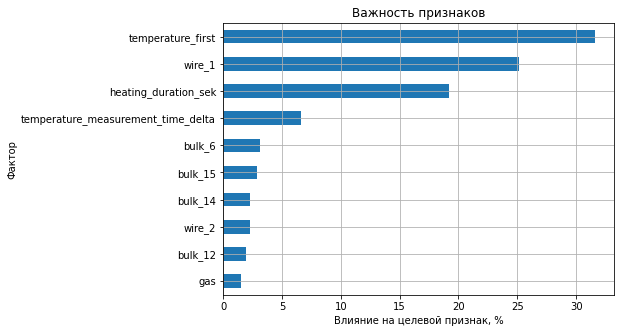

In [78]:
importance.tail(10).plot.barh(x='feature_names', y='feature_importance', legend=False, figsize=(7,5), grid=True)
plt.title('Важность признаков')
plt.xlabel('Влияние на целевой признак, %')
plt.ylabel('Фактор')
plt.show()

Наибольшее влияние на целевой признак оказывают: 
- начальная температура расплава
- количество легирующей добавки в виде проволоки wire_1
- продолжительность нагрева электродами.

# Отчет

В план работы входили следующие пункты:
1. Провести статистический анализ данных
2. Объединить таблицы с признаками в одну, оставить необходимые признаки
3. Разделить данные на признаки и целевой признак. Разделить на тестовую, валидационную и тренировочную выборки
4. Обучить различные модели, сравнить качество, проанализировать результат. При необходимости, провести более тщательную предобработку данных, возможно сделть генерацию дополнительных признаков. Выбрать оптимальную модель
5. Сделать выводы по работе

Все пункты плана были выполнены.

Итоговая модель - CatBoostRegressor. MAE данной модели на тестовой выборке составляет 5.29